# Plot sea ice volume tendency components

Plot the thermodynamic and dynamic volume tendency components. Both are calculated online.

In [74]:
import numpy as np
import xarray as xr
import pandas as pd
import cmocean as cmo
import matplotlib.pyplot as plt
import subprocess

import matplotlib.gridspec as gridspec

User inputs

In [1]:
#model info
diri      = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/RAW/'
cntr_expt = 'metroms_CONTROL' 
pert_expt = 'metroms_4SSFLUX'
varname   = ['dvidtt','dvidtd']  #variable names

#time domain for each experimnt

#2003 is only available from august

yrst = 2002 ; mst = 2
yren = 2011 ; men = 1 

#spatial domain (self-explanotory)
latmax = -50.
lonmin = 150.
lonmax = 300. 

#output file destination
diro = ''

In [3]:
path_to_data = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/POST_PROCESS/'

Function to read data for each expt

In [8]:
def get_dat(ename):
    
    yrstr = [str(int) for int in  np.arange(yrst, 1+yren) ] 
    CMD  = 'ls '+diri+ename+'/cice/history/iceh.{'+','.join(yrstr)+'}-??-??.nc'
    fili = subprocess.run(CMD, shell=True, capture_output=True)  #run CMD as a bash command
    fili = fili.stdout.decode().split('\n')[0:-1] 
    
    data = xr.open_mfdataset(fili, parallel=True)
    var  = data[varname]
   
    #reduce to specified spatial domain
    var = var.where((data.TLAT <= latmax) & (data.TLON >= lonmin) & (data.TLON <= lonmax), drop=True)
      
    #get time mean of required time domain
    stdat = str(yrst)+'-'+str(mst) ; endat = str(yren)+'-'+str(men)
    var   = var.sel(time = slice(stdat,endat))#.mean('time')
               
    return var

In [23]:
%%time
cntr = get_dat(cntr_expt).load()

CPU times: user 15min 31s, sys: 3min 19s, total: 18min 50s
Wall time: 20min 8s


In [43]:
cntr.to_netcdf(path_to_data + 'dvdt_CONTROL_2002_2011.nc')

In [44]:
%%time
pert = get_dat(pert_expt).load()
pert.to_netcdf(path_to_data + 'dvdt_4SSFLUX_2002_2011.nc')

CPU times: user 15min 17s, sys: 3min 38s, total: 18min 56s
Wall time: 21min 12s


Or import previously loaded data

In [4]:
cntr = xr.open_dataset(path_to_data + 'dvdt_CONTROL_2002_2011.nc')
pert = xr.open_dataset(path_to_data + 'dvdt_4SSFLUX_2002_2011.nc')

Plotting information

In [9]:
# Spherical coordinates
deg2rad = np.pi/180.0

# CICE
x_cice = -(cntr.TLAT+90)*np.cos(cntr.TLON*deg2rad+np.pi/2)
y_cice =  (cntr.TLAT+90)*np.sin(cntr.TLON*deg2rad+np.pi/2)

In [20]:
# Load roms data for plotting
roms = xr.open_dataset('/g/data/gh9/wgh581/ROMS_Output/metroms_files/' + 'RAW/metroms_CONTROL/' + 'ocean_his_0042.nc')
lat_roms = roms.lat_rho.where((roms.lat_rho <= latmax) & (roms.lon_rho >= lonmin) & (roms.lon_rho <= lonmax), drop=True)
lon_roms = roms.lon_rho.where((roms.lat_rho <= latmax) & (roms.lon_rho >= lonmin) & (roms.lon_rho <= lonmax), drop=True)
zice     = roms.zice.where((roms.lat_rho <= latmax) & (roms.lon_rho >= lonmin) & (roms.lon_rho <= lonmax), drop=True)
h        = roms.h.where((roms.lat_rho <= latmax) & (roms.lon_rho >= lonmin) & (roms.lon_rho <= lonmax), drop=True)
mask     = roms.mask_rho.where((roms.lat_rho <= latmax) & (roms.lon_rho >= lonmin) & (roms.lon_rho <= lonmax), drop=True)

In [24]:
# Masking
h     = np.ma.masked_where(mask==0, h)
zice  = np.ma.masked_where(mask==0, zice)
zice  = np.ma.masked_where(zice==0, zice)
lat_r = np.ma.masked_where(mask==1, lat_roms)

In [26]:
# ROMS
x_roms = -(lat_roms+90)*np.cos(lon_roms*deg2rad+np.pi/2)
y_roms =  (lat_roms+90)*np.sin(lon_roms*deg2rad+np.pi/2)

In [ ]:
# # Center of missing circle (ROMS)
# lat_c   = -83
# lon_c   = 50
# # Radius of missing circle (play around with this until it works)
# radius  = 10.1
# # Find center in spherical coordinates
# x_c_metroms = -(lat_c+90)*np.cos(lon_c*deg2rad+np.pi/2)
# y_c_metroms =  (lat_c+90)*np.sin(lon_c*deg2rad+np.pi/2)
# # Build a regular x-y grid and select the missing circle
# lat_max = -63+90
# x_reg, y_reg = meshgrid(linspace(-lat_max, lat_max, num=1000), linspace(-lat_max, lat_max, num=1000))
# land_circle = zeros(shape(x_reg))
# land_circle_metroms = ma.masked_where(sqrt((x_reg-x_c_metroms)**2 + (y_reg-y_c_metroms)**2) > radius, land_circle)

In [60]:
# Region range
xlim_min = -25
xlim_max = 15
ylim_min = -30
ylim_max = 7

In [27]:
pert

<xarray.Dataset>
Dimensions:  (time: 656, nj: 328, ni: 598)
Coordinates:
  * time     (time) datetime64[ns] 2002-02-12 2002-02-17 ... 2011-01-31
    TLON     (nj, ni) float32 ...
    TLAT     (nj, ni) float32 ...
    ULON     (nj, ni) float32 ...
    ULAT     (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Data variables:
    dvidtt   (time, nj, ni) float32 ...
    dvidtd   (time, nj, ni) float32 ...
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model (CICE) Version 5
    comment:      This year has 365 days
    comment2:     File written on model date 20020212
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2019-03-13 at 23:23:41.8
    io_flavor:    io_netcdf

Annual average, full time period

In [30]:
# Anomaly between perturbation and control simulation
diff_t = pert.dvidtt.mean('time') - cntr.dvidtt.mean('time')
diff_d = pert.dvidtd.mean('time') - cntr.dvidtd.mean('time')

In [33]:
# Total volume tendency (dynamic + thermodynamic)
diff_total = (diff_t + diff_d)
# cm/day -> cm/year
diff_total.values = diff_total.values * 365.

/jobfs/67342504.gadi-pbs/ipykernel_63971/3205406314.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_cice, y_cice, tmp, vmin=-20, vmax=20, cmap=cmo.cm.balance)
/jobfs/67342504.gadi-pbs/ipykernel_63971/3205406314.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_cice, y_cice, cntr.dvidtt.mean('time'), vmin=-1, vmax=1, cmap=cmo.cm.balance)
/jobfs/67342504.gadi-pbs/ipykernel_63971/3205406314.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead t

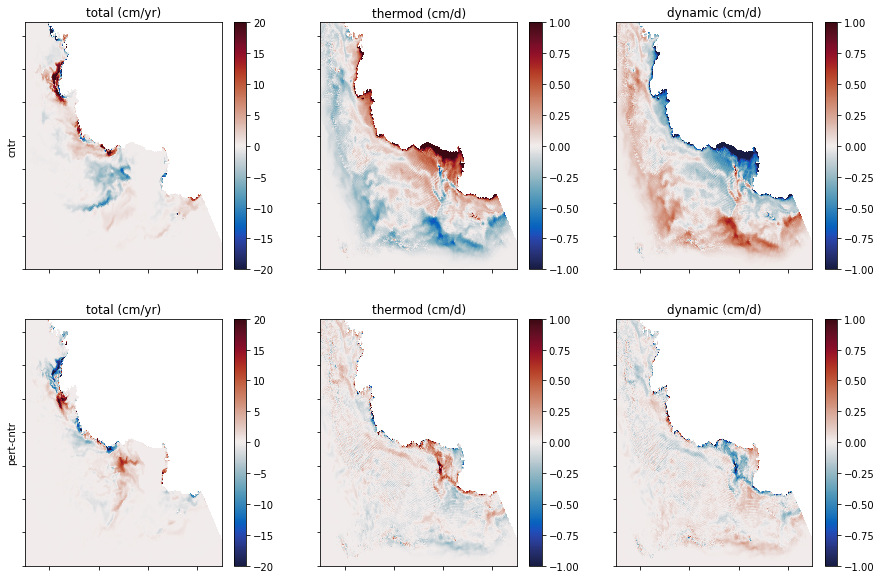

In [87]:
fig = plt.figure(figsize=(15,10))

plt.subplot(231)
tmp = cntr.dvidtt.mean('time')+cntr.dvidtd.mean('time')
tmp.values = tmp.values * 365
plt.pcolormesh(x_cice, y_cice, tmp, vmin=-20, vmax=20, cmap=cmo.cm.balance)
plt.title('total (cm/yr)')
plt.colorbar()
plt.ylabel('cntr')
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.tick_params(labelleft=False, labelbottom=False)

plt.subplot(232)
plt.pcolormesh(x_cice, y_cice, cntr.dvidtt.mean('time'), vmin=-1, vmax=1, cmap=cmo.cm.balance)
plt.title('thermod (cm/d)')
plt.colorbar()
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.tick_params(labelleft=False, labelbottom=False)

plt.subplot(233)
plt.pcolormesh(x_cice, y_cice, cntr.dvidtd.mean('time'), vmin=-1, vmax=1, cmap=cmo.cm.balance)
plt.title('dynamic (cm/d)')
plt.colorbar()
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.tick_params(labelleft=False, labelbottom=False)

plt.subplot(234)
plt.pcolormesh(x_cice, y_cice, diff_total, vmin=-20, vmax=20, cmap=cmo.cm.balance)
plt.title('total (cm/yr)')
plt.colorbar()
plt.ylabel('pert-cntr')
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.tick_params(labelleft=False, labelbottom=False)

plt.subplot(235)
plt.pcolormesh(x_cice, y_cice, diff_t, vmin=-1, vmax=1, cmap=cmo.cm.balance)
plt.title('thermod (cm/d)')
plt.colorbar()
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.tick_params(labelleft=False, labelbottom=False)

plt.subplot(236)
plt.pcolormesh(x_cice, y_cice, diff_d, vmin=-1, vmax=1, cmap=cmo.cm.balance)
plt.title('dynamic (cm/d)')
plt.colorbar()
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.tick_params(labelleft=False, labelbottom=False);

Seasonal climatology, full time period

In [46]:
# Anomaly between perturbation and control simulation
diff_t_seasonal = pert.dvidtt.groupby('time.season').mean('time') - cntr.dvidtt.groupby('time.season').mean('time')
diff_d_seasonal = pert.dvidtd.groupby('time.season').mean('time') - cntr.dvidtd.groupby('time.season').mean('time')

In [47]:
# Total volume tendency (dynamic + thermodynamic)
diff_total_seasonal = (diff_t_seasonal + diff_d_seasonal)
# cm/day -> cm/year
#diff_total_seasonal.values = diff_total_seasonal.values * 365.

In [77]:
season = ['DJF', 'MAM', 'JJA', 'SON']
ft_size=16

/jobfs/67342504.gadi-pbs/ipykernel_63971/970917625.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_total_seasonal[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance)
/jobfs/67342504.gadi-pbs/ipykernel_63971/970917625.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_t_seasonal[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance)
/jobfs/67342504.gadi-pbs/ipykernel_63971/970917625.py:33: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decrea

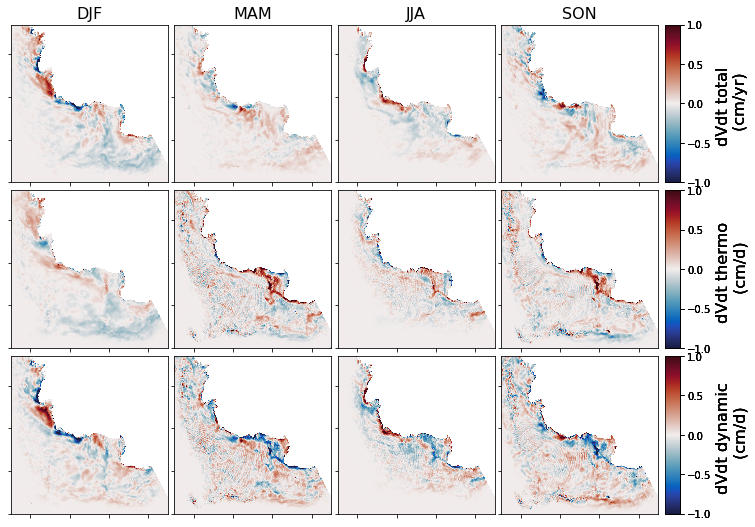

In [85]:
fig = plt.figure(figsize=(12,9))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)

for ii in range(4):
    
    ax = fig.add_subplot(gs0[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_total_seasonal[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance)
    plt.title(season[ii], fontsize=ft_size)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.tick_params(labelleft=False, labelbottom=False)
    cbar_ax0 = fig.add_subplot(gs0[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0)
    cbar.set_label('dVdt total \n (cm/yr)', fontsize=ft_size)

    ax = fig.add_subplot(gs1[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_t_seasonal[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.tick_params(labelleft=False, labelbottom=False)
    cbar_ax0 = fig.add_subplot(gs1[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0)
    cbar.set_label('dVdt thermo \n (cm/d)', fontsize=ft_size)
    
    ax = fig.add_subplot(gs2[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_d_seasonal[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.tick_params(labelleft=False, labelbottom=False)
    cbar_ax0 = fig.add_subplot(gs2[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0)
    cbar.set_label('dVdt dynamic \n (cm/d)', fontsize=ft_size)